# 30 Day Map Challenge: Day 1 (Points)

This is a notebook for day 1 of [30 Day Map Challenge](https://30daymapchallenge.com/), which also doubles as an example notebook for lonboard.

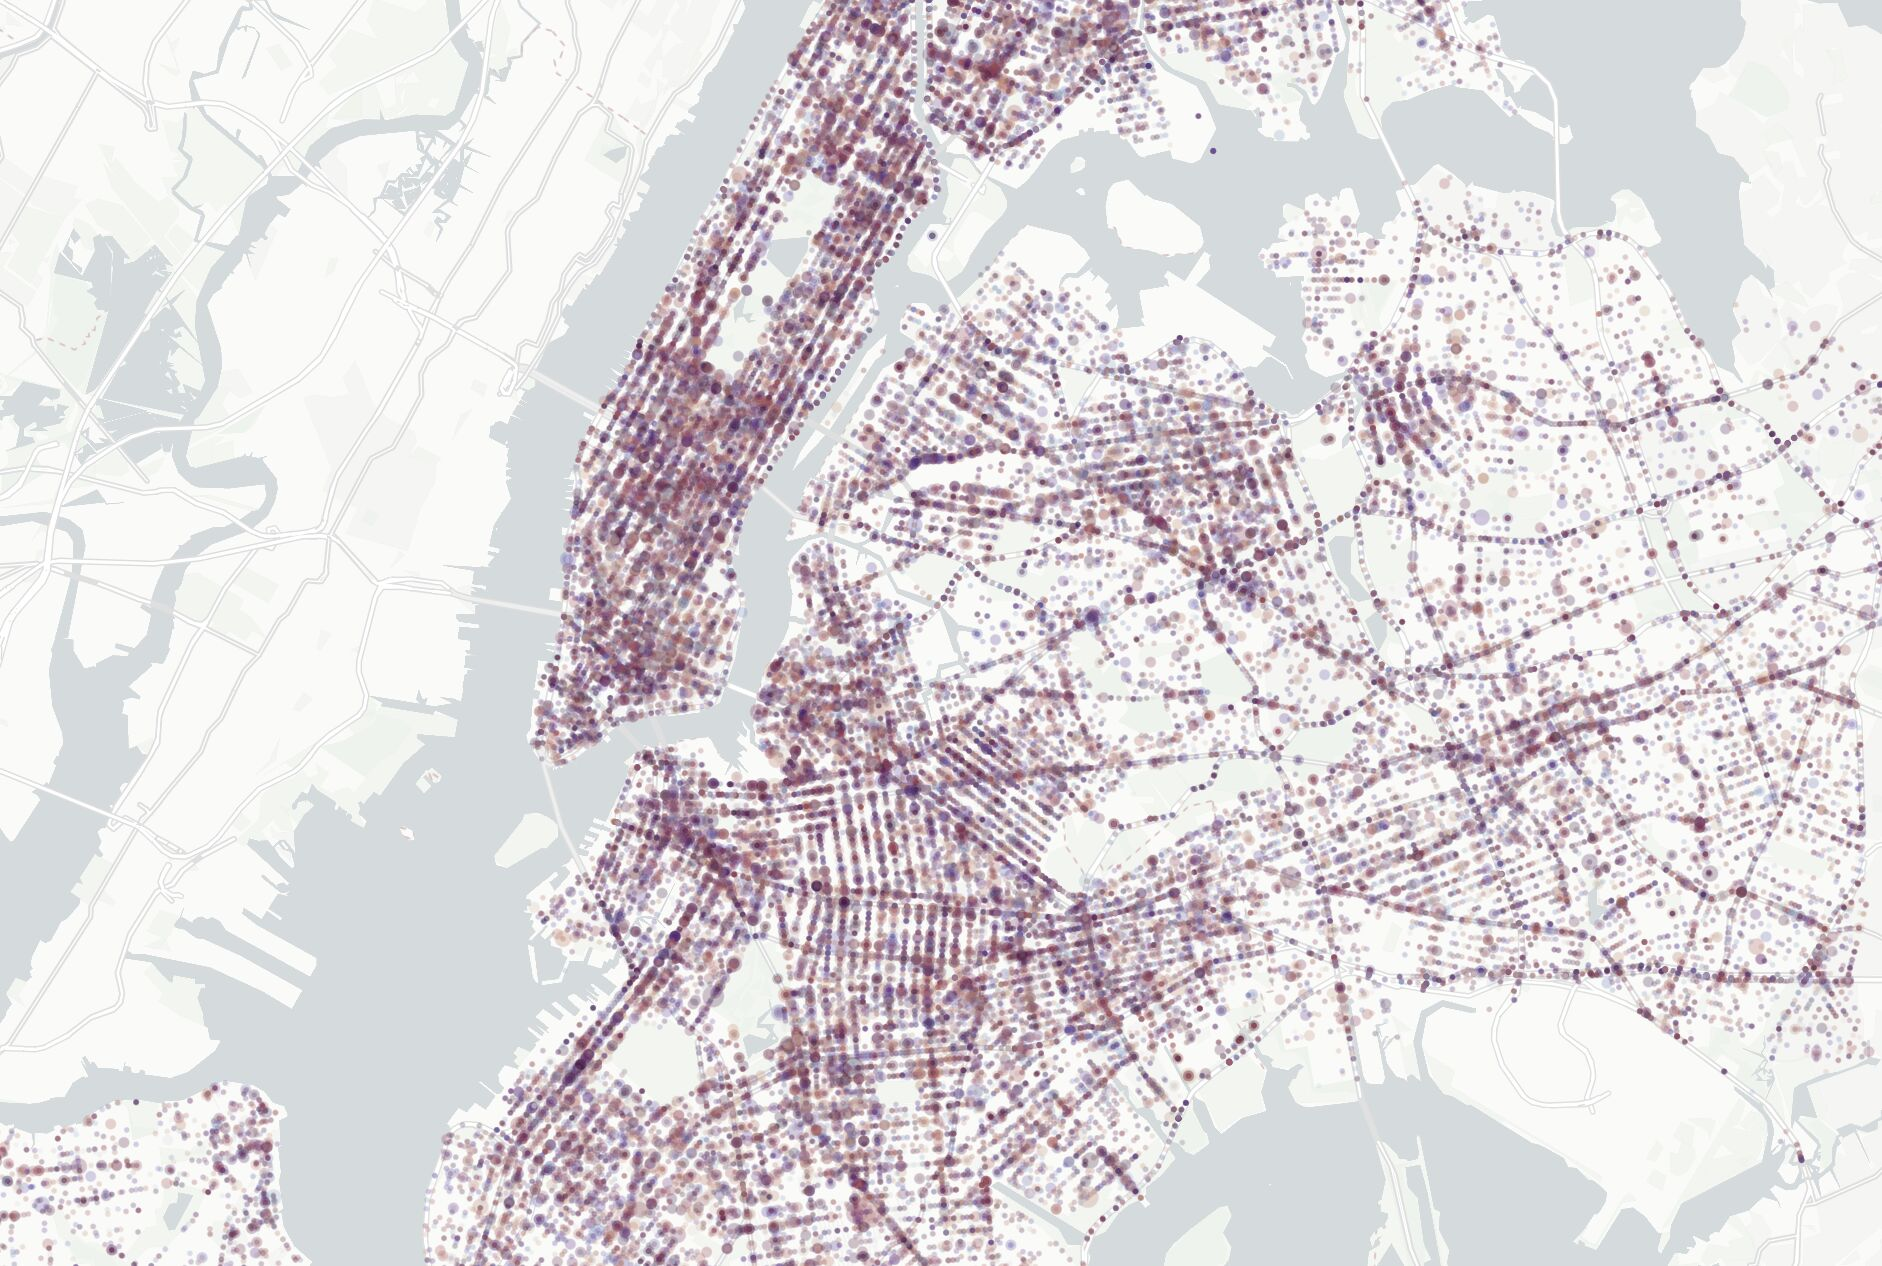

## Imports

In [1]:
import geopandas as gpd
import matplotlib as mpl
import numpy as np
import pandas as pd
import shapely

from lonboard import Map, ScatterplotLayer

## Access the data

This data comes from NYC Open Data, where we use [Motor Vehicle Collisions - Crashes](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95). First download this data via `Export > CSV`, save it somewhere on disk, and update the `path` variable in the next cell for that location.

In [2]:
path = "/Users/kyle/Downloads/Motor_Vehicle_Collisions_-_Crashes_20231101.csv"

Read the data:

In [3]:
df = pd.read_csv(path, dtype={"ZIP CODE": str})

Let's first take a peek at our data:

In [4]:
pd.options.display.max_columns = None
df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,2.0,0.0,0,0,0,0,2,0,Aggressive Driving/Road Rage,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,1.0,0.0,0,0,0,0,1,0,Pavement Slippery,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
3,09/11/2021,9:35,BROOKLYN,11208,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,12/14/2021,8:13,BROOKLYN,11233,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,0.0,0.0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN


There are a bunch of columns in this dataset:

In [5]:
df.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')

Let's keep only specific columns that we care about:

In [6]:
keep_cols = [
    "CRASH DATE",
    "CRASH TIME",
    "LATITUDE",
    "LONGITUDE",
    "NUMBER OF PERSONS INJURED",
    "NUMBER OF PERSONS KILLED",
    "NUMBER OF PEDESTRIANS INJURED",
    "NUMBER OF PEDESTRIANS KILLED",
    "NUMBER OF CYCLIST INJURED",
    "NUMBER OF CYCLIST KILLED",
    "NUMBER OF MOTORIST INJURED",
    "NUMBER OF MOTORIST KILLED",
    "COLLISION_ID",
]
df = df[keep_cols]

About 11% of the data have missing locations. For this quick demo, I don't have the ability to georeference those rows based on street name, so we'll just remove them. Hopefully there isn't a skew where crashes in some areas are more likely to not be georeferenced.

In [7]:
(df["LONGITUDE"].isnull() | df["LATITUDE"].isnull()).mean()

0.11342612579376604

Keep only the rows where longitude and latitude are not null.

In [8]:
df = df[(df["LONGITUDE"].notnull() & df["LATITUDE"].notnull())]

This dataset has crash data from the end of 2021, all of 2022, and thus far in 2023. For simplicity and regularity, let's choose only data from 2022.

We'll convert the date to a datetime column and then select rows where the date happened in 2022:

In [9]:
df["CRASH DATE"] = pd.to_datetime(df["CRASH DATE"])
df = df[df["CRASH DATE"].dt.year == 2022]

Let's also convert the time column from a string to a timestamp. 

In [10]:
df["CRASH TIME"] = pd.to_datetime(df["CRASH TIME"], format="%H:%M")

If we look at the data types in our data, they were inferred as `int64` and `float64` data types:

In [11]:
df.dtypes

CRASH DATE                       datetime64[ns]
CRASH TIME                       datetime64[ns]
LATITUDE                                float64
LONGITUDE                               float64
NUMBER OF PERSONS INJURED               float64
NUMBER OF PERSONS KILLED                float64
NUMBER OF PEDESTRIANS INJURED             int64
NUMBER OF PEDESTRIANS KILLED              int64
NUMBER OF CYCLIST INJURED                 int64
NUMBER OF CYCLIST KILLED                  int64
NUMBER OF MOTORIST INJURED                int64
NUMBER OF MOTORIST KILLED                 int64
COLLISION_ID                              int64
dtype: object

Knowing that our data holds small values, we can downcast to smaller data types:

In [12]:
for numeric_col_name in df.select_dtypes("number").columns:
    df[numeric_col_name] = pd.to_numeric(df[numeric_col_name], downcast="unsigned")

Now our data types are much smaller:

In [13]:
df.dtypes

CRASH DATE                       datetime64[ns]
CRASH TIME                       datetime64[ns]
LATITUDE                                float64
LONGITUDE                               float64
NUMBER OF PERSONS INJURED                 uint8
NUMBER OF PERSONS KILLED                  uint8
NUMBER OF PEDESTRIANS INJURED             uint8
NUMBER OF PEDESTRIANS KILLED              uint8
NUMBER OF CYCLIST INJURED                 uint8
NUMBER OF CYCLIST KILLED                  uint8
NUMBER OF MOTORIST INJURED                uint8
NUMBER OF MOTORIST KILLED                 uint8
COLLISION_ID                             uint32
dtype: object

Now let's construct a GeoDataFrame from this data. 

In [14]:
geometry = shapely.points(df.pop("LONGITUDE"), df.pop("LATITUDE"))
gdf = gpd.GeoDataFrame(df, geometry=geometry)

In [15]:
gdf.head()

,CRASH DATE,CRASH TIME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID,geometry
37,2022-07-12,1900-01-01 17:50:00,0,0,0,0,0,0,0,0,4545699,POINT (-73.96049 40.66330)
40,2022-04-24,1900-01-01 16:45:00,1,0,0,0,0,0,1,0,4521660,POINT (-74.13892 40.60768)
41,2022-04-24,1900-01-01 04:49:00,0,0,0,0,0,0,0,0,4521759,POINT (-73.86990 40.85597)
42,2022-04-22,1900-01-01 17:17:00,1,0,1,0,0,0,0,0,4522226,POINT (-73.93960 40.79028)
43,2022-04-24,1900-01-01 01:30:00,0,0,0,0,0,0,0,0,4522015,POINT (-74.01621 40.64299)


If we look at the bounding box of our data, we see that some points are way outside of NYC. Let's filter to include only the data in the NYC region:

In [16]:
gdf.total_bounds

array([-74.25496 ,   0.      ,   0.      ,  40.912167])

In [17]:
nyc_bbox = [-74.382742, 40.428857, -73.452477, 41.092696]

In [18]:
gdf = gdf[gdf.intersects(shapely.box(*nyc_bbox))]

In [19]:
layer = ScatterplotLayer.from_geopandas(gdf)
map = Map(layers=[layer], _height=800)
map

Map(layers=[ScatterplotLayer(table=pyarrow.Table
CRASH DATE: timestamp[ns]
CRASH TIME: timestamp[ns]
NUMBER OF…

Ok cool, we can see something on the map, but let's make our visualization more interesting.

Let's compute the number of non-motorists injured in each collision:

In [20]:
num_injured = gdf["NUMBER OF PEDESTRIANS INJURED"] + gdf["NUMBER OF CYCLIST INJURED"]

We can see a quick distribution with `value_counts`

In [21]:
num_injured.value_counts()

0    80613
1    12057
2      356
3       37
4        3
5        3
Name: count, dtype: int64

In [22]:
layer.get_radius = np.array(num_injured + 1)
layer.radius_scale = 50
layer.opacity = 0.05

Next, let's color each dot by time of day. We'll use a [_cyclic_](https://matplotlib.org/stable/users/explain/colors/colormaps.html#cyclic) colormap that starts and ends on the same color, because the time of day is cyclic.

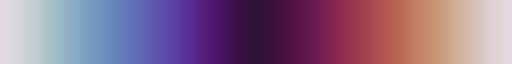

In [23]:
colormap = mpl.colormaps["twilight"]
colormap

Next get the minute of day of the crash:

In [24]:
minute_of_day = gdf["CRASH TIME"].dt.hour * 60 + gdf["CRASH TIME"].dt.minute

To apply a colormap, we need to normalize the `minute_of_day` series to `0-1`. We can do this with matplotlib's [`Normalize`](https://matplotlib.org/stable/users/explain/colors/colormapnorms.html#colormap-normalization). We set the minimum value to 0 and the maximum value to the number of minutes in a day.

In [25]:
normalizer = mpl.colors.Normalize(0, 24 * 60)
normalized_minutes = normalizer(minute_of_day)

Now `normalized_minutes` ranges from 0-1:

In [26]:
normalized_minutes

masked_array(data=[0.74305556, 0.69791667, 0.20069444, ..., 0.54166667,
                   0.625     , 0.60069444],
             mask=False,
       fill_value=1e+20)

Next we can apply the matplotlib colormap on our normalized values. We set `bytes=True` to ensure the output is of `uint8` data type.

In [27]:
colors = colormap(normalized_minutes, bytes=True)

In [28]:
colors

array([[175,  81,  81, 255],
       [156,  57,  79, 255],
       [109, 144, 191, 255],
       ...,
       [ 63,  17,  60, 255],
       [115,  29,  78, 255],
       [ 99,  24,  75, 255]], dtype=uint8)

In [29]:
layer.get_fill_color = colors